# Setup

In [1]:
import numpy as np
import pylab as plt
from ipywidgets import interact

ground_truth = lambda x: x * np.sin(x*2)
def get_data(ground_truth, n_samples, noise=0.5):
    X = np.random.uniform(0, 6, n_samples)
    y = ground_truth(X) + np.random.randn(*X.shape)*noise
    return X, y

# Gaussian Processes

In this exercise, we will implement a Gaussian process for regession.

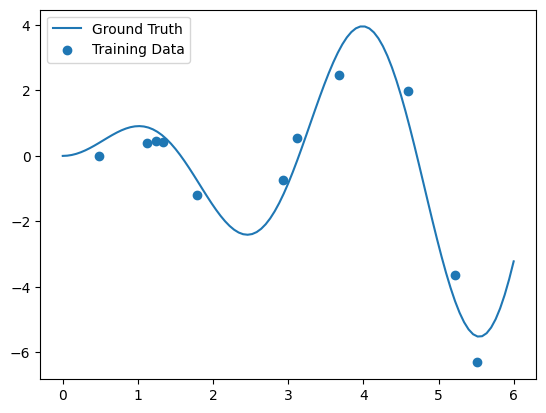

In [2]:
np.random.seed(5)
X, y = get_data(ground_truth, n_samples=11)
axis = np.linspace(0, 6, 101)

plt.plot(axis, ground_truth(axis), label='Ground Truth')
plt.scatter(X, y, label='Training Data')
plt.legend()
plt.show()

## Kernel functions
Implement the kernel functions which are defined below.

> Exponential Covariance (Equation 6.63): $$k(\mathbf{x}_n, \mathbf{x}_m)  = \theta_0 \exp\left( - \frac{\theta_1}{2} \Vert \mathbf{x}_n - \mathbf{x}_m \Vert^2 \right) + \theta_2 + \theta_3 \mathbf{x}_n^T\mathbf{x}_m.$$
> Exponential Kernel (Equation 6.56): $$k\left(x, x^{\prime}\right)=\exp \left(-\theta\left|x-x^{\prime}\right|\right)$$

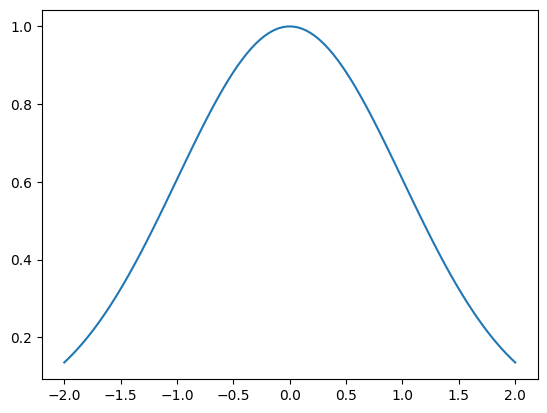

In [3]:
class ExponentialCovariance:
    """Gaussian kernel from Eq. 6.63."""
    def __init__(self, theta0=1, theta1=1, theta2=0, theta3=0):
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = np.array(theta3)
        

    def __call__(self, x, y):
        x = np.array(x, ndmin=2)
        y = np.array(y, ndmin=2)
        return self.theta0 * np.exp(-self.theta1/2 * np.linalg.norm(x - y)**2) + self.theta2 + self.theta3 * (x.T @ y)
    
kernel = ExponentialCovariance()
kernel(2, 1) # should return 0.6065306597126334
y = []
x = np.linspace(-2, 2, 100)
for x_ in x:
    y.append(kernel(x_, 0))

plt.plot(x, np.array(y).squeeze())
plt.show()

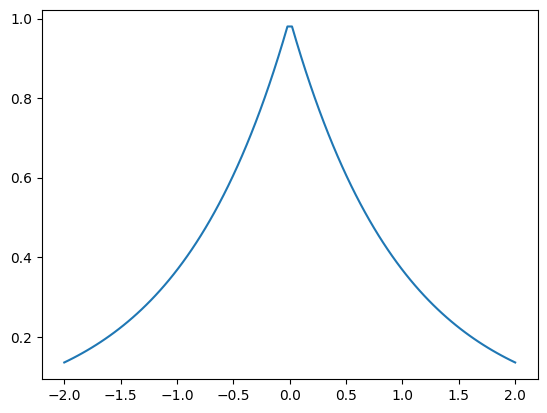

In [4]:
class ExponentialKernel:
    """Exponential kernel from Eq. 6.56."""
    def __init__(self, theta=1):
        self.theta = theta

    def __call__(self, x, y):
        x = np.array(x, ndmin=2)
        y = np.array(y, ndmin=2)
        return np.exp(-self.theta * np.abs(x - y))
kernel = ExponentialKernel()
kernel(2, 1) # should return 0.36787944117144233
y = []
x = np.linspace(-2, 2, 100)
for x_ in x:
    y.append(kernel(x_, 0))

plt.plot(x, np.array(y).squeeze())
plt.show()

        Feel free to implement additional kernels from the lecture. They can be used in the resulting GP model.

## Prior Distribution

> Implment the class `GaussianProcess` with the following methods:
> - `__init__`: Initializes all hyperparameters of our model. In this case we need the corresponding kernel function we want to use.
> - `prior_samples`: Provides random samples from the prior distribution over functions.


In [5]:
class GaussianProcess:
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func

    def prior_samples(self, X, n_samples):# Vorlesung 6, Folie 21
        self.K = np.array([[self.kernel_func(x1, x2) for x1 in X] for x2 in X]).squeeze()
        return np.random.multivariate_normal(np.zeros(len(X)), self.K, n_samples)

> Plot samples according to the figure on slide 18.

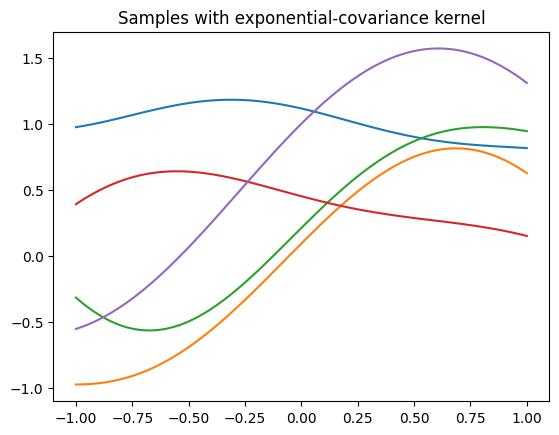

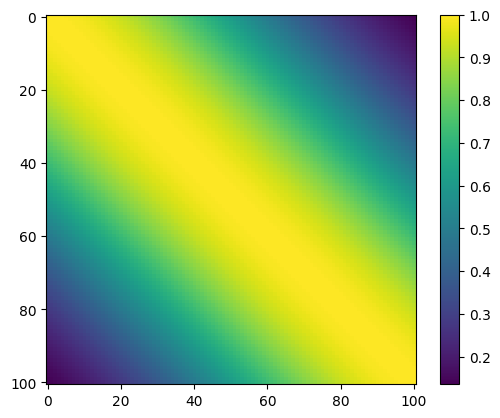

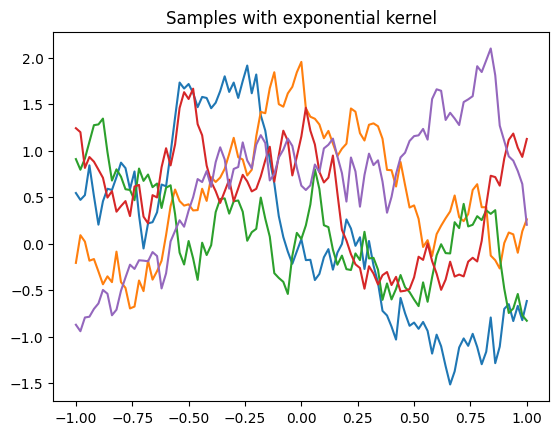

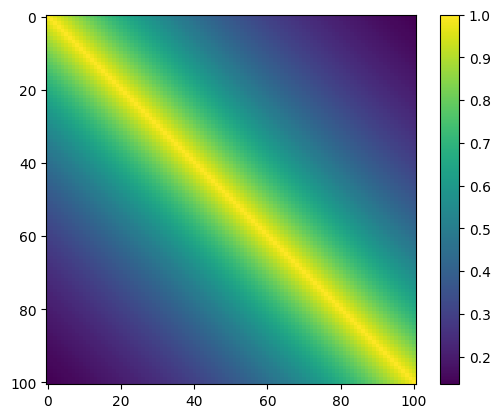

In [6]:
gp = GaussianProcess(ExponentialCovariance())# exponent of e-function is negative and thus, negative squared distance as exponent -> extremely small values
axis = np.linspace(-1, 1, 101)
plt.title("Samples with exponential-covariance kernel")
plt.plot(axis, gp.prior_samples(axis, 5).T)
plt.show()

plt.imshow(gp.K)# broader covariance matrix -> less spiky
plt.colorbar()
plt.show()
# intuitions: if kernel is broader, covariance matrix is broader/data points stay similar 'longer', thus, less spiky
# bc our kernel is very broad, distant points are considered similar and we've spiky data points since wide variety of equally likely targets (bc of broad kernel)

gp = GaussianProcess(ExponentialKernel())   # exponent of e-function is negative and thus, negative distance as exponent -> more spiky, bc greater changes than in exponential-covariance kernel
axis = np.linspace(-1, 1, 101)
plt.title("Samples with exponential kernel")
plt.plot(axis, gp.prior_samples(axis, 5).T)
plt.show()

plt.imshow(gp.K)# narrower covariance matrix -> more spiky
plt.colorbar()
plt.show()


## Conditional distribution

Our ultimate goal is to find the predictive distribution. That is, we seek to evaluate  $p(t_{N+1}| \mathbf{t})$ for a new sample $\mathbf{x}_{N+1}$.
In order to find the conditional distribution $p(t_{N+1}| \mathbf{t})$:
1. We start by writing down the joint distribution $p(\mathbf{t}_{N+1})$, where $\mathbf{t}_{N+1}$ denotes the vector $(t_1,\ldots,t_N, t_{N+1})^T$.
2. We then apply the results from Section 2.3.1 to obtain the required conditional distribution.

### Joint Distribution
The joint distribution over $t_1, \ldots, t_{N+1}$ will be given by $$\quad p(\mathbf{t}_{N+1}) = \mathcal{N}(\mathbf{t}_{N+1}| \mathbf{0}, \mathbf{C}_{n+1})$$
where $\mathbf{C}_{N+1}$ is an $(N+1)\times(N+1)$ covariance matrix with elements given by $$\quad C\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+\beta^{-1} \delta_{n m}$$
where $\beta$ is a hyperparameter representing the precision of the noise.
Because the joint distribution is Gaussian, we can apply the results from Section 2.3.1 to find the conditional Gaussian distribution. To do this, we partition the covariance matrix as follows
$$\quad \textbf{C}_{N+1} =  \left( \begin{array}{cc} \textbf{C}_{N} & \textbf{k}  \\ \textbf{k}^{T} & c  \\ \end{array} \right)$$ where $\mathbf{C}_N$ is the $N \times N$ covariance matrix, the vector $\mathbf{k}$ has elements $k(\mathbf{x}_n, \mathbf{x}_{N+1})$ for $n = 1,\ldots,N$, and the scalar $c = k(\mathbf{x}_{N+1}, \mathbf{x}_{N+1}) + \beta^{-1}$. We see that the conditional distribution $p(t_{N+1}|\mathbf{t})$ is a Gaussian distribution with mean and covariance given by
$$\quad m(\mathbf{x}_{N+1}) = \mathbf{k}^T \mathbf{C}_N^{-1}\mathbf{t} \quad \quad \sigma^2 (\mathbf{x}_{N+1}) =  c - \mathbf{k}^T\mathbf{C}_n^{-1}\mathbf{k}$$

The only restriction on the kernel function is that the covariance matrix must be positive definite. If $\lambda_i$ is an eigenvalue of $\mathbf{K}$, then the corresponding eigenvalue of $\mathbf{C}$ will be $\lambda_i + \beta^{-1}$.
It is therefore sufficient that the kernel matrrix $k(\mathbf{x}_n, \mathbf{x}_m)$ be positive semidefinite for any pair of points $\mathbf{x}_n$ and $\mathbf{x}_m$, so that $\lambda_i \geq 0$, because any eigenvalue $\lambda_i$ that is zero will still give rise to a positive eigenvalue for $\mathbf{C}$ because $\beta \ge 0$.

Note that the mean (6.66) of the predictive distribution can be written, as a function of $\mathbf{x}_{N+1}$, in the form  $$\quad m(\mathbf{x}_{N+1}) = \sum_{n=1}^{N} a_n k(\mathbf{x}_n \mathbf{x}_{N+1})$$ where $a_n$ is the $\text{n}^{\text{th}}$ component of $\mathbf{C}_N^{-1}\mathbf{t}$. Thus, if the kernel $k(\mathbf{x}_n, \mathbf{x}_m)$ depends only on the distance $\Vert \mathbf{x}_n - \mathbf{x}_m \Vert$, then we obtain an expansion on radial basis functions.
The results (6.66) and (6.67) define the predictive distribution for Gaussian process regression with an arbitrary kernel function $k(\mathbf{x}_n, \mathbf{x}_m)$.
> Implement the predict function based on Eq. 6.68 and extend this idea for the confidence sigma. Don't forget to extend previous functions to include the noise.

In [7]:
class CondGaussianProcess(GaussianProcess):
    def fit(self, X, y, noise=.1):
        # X = x_0, ..., x_N
        # y = t_0, ..., t_N
        # kernel funct kommt von GaussianProcess
        # noise is beta^-1 -> do not invert
        self.X = X
        self.target = y
        self.noise = noise
        self.C = np.array([[self.kernel_func(x1, x2).squeeze() for x1 in X] for x2 in X])
        self.C += np.eye(len(X)) * noise


    def predict_conditional(self, input):
        k = np.array([self.kernel_func(x, input).squeeze() for x in self.X])
        c = self.kernel_func(input, input) + self.noise
        mean = k.T @ np.linalg.inv(self.C) @ self.target
        var = c - k.T @ np.linalg.inv(self.C) @ k
        #pred = np.random.normal(mean, var)
        return mean, var


> Plot the predictions of the Gaussian Process with the corresponding dataset. Plot the standard deviation as done [here](https://stackoverflow.com/questions/45136420/filling-range-of-graph-in-matplotlib).

small noise -> C is almost the same as K, thus, we want to interpolate the data points

big noise -> C is very different from K, target values are very different from the data points

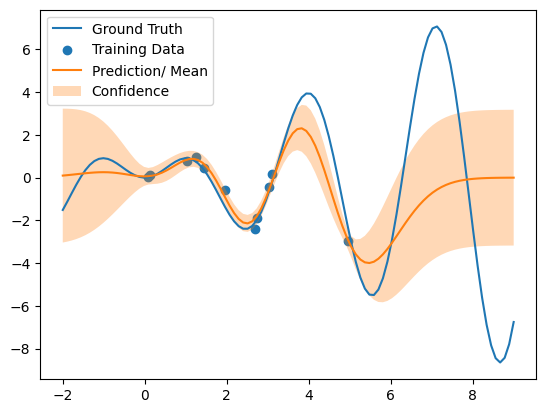

In [8]:
X, y = get_data(ground_truth, n_samples=11)
x_axis = np.linspace(-2, 9, 101)
gp = CondGaussianProcess(ExponentialCovariance(theta0=10))
gp.fit(X, y, noise=.1)
output = [gp.predict_conditional(x) for x in x_axis]
y_pred = np.array([o[0] for o in output]).squeeze()
std = np.array([np.sqrt(o[1]) for o in output]).squeeze()

plt.plot(x_axis, ground_truth(x_axis), label='Ground Truth')
plt.scatter(X, y, label='Training Data')
plt.ylim(plt.ylim())
plt.plot(x_axis, y_pred, label='Prediction/ Mean')
plt.fill_between(x_axis, y_pred - std, y_pred + std, alpha=.3, label='Confidence')
plt.legend()

plt.show()

> Test your code with the following interactive plot and modify the parameters to be get an intuitive understanding for the behavior of the kernel.
> You might have to adapt the code if it is not working out of the box with your own implementation.

In [13]:
def plot_predict_conditional(noise=.2, theta0=1, theta1=1, theta2=0, theta3=0):
    kernel_func = ExponentialCovariance(theta0=theta0, theta1=theta1, theta2=theta2, theta3=theta3)
    gp = CondGaussianProcess(kernel_func)
    gp.fit(X, y, noise=noise)

    fig = plt.figure(figsize=(13, 5))
    axis = np.linspace(min(X)-2, max(X)+2, 101)

    preds = [gp.predict_conditional(x) for x in axis]
    mean_pred = np.array([o[0] for o in preds]).squeeze()
    var_pred = np.array([np.sqrt(o[1]) for o in preds]).squeeze()
    plt.plot(axis, mean_pred)
    plt.fill_between(axis, mean_pred - np.sqrt(var_pred), mean_pred + np.sqrt(var_pred), alpha=.3)
    plt.scatter(X, y)

interact(plot_predict_conditional,  noise=(0.01, 1, 0.01), theta0=(0, 5, .1), theta1=(0, 5, .1), theta2=(0, 5, .1), theta3=(0, 5, .1))
plt.show()

interactive(children=(FloatSlider(value=0.2, description='noise', max=1.0, min=0.01, step=0.01), FloatSlider(v…